In [1]:
import numpy as np
import pandas as pd
import os

import re
from ast import literal_eval
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 33M Feb 13 11:48 data/Byvsij_SSSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 75M Feb 13 11:35 data/Ekonomika.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 51M Feb 13 11:45 data/Mir.csv.bz2


In [3]:
name_dataset = 'Byvsij_SSSR'

### load data

In [4]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(45046, 6)
CPU times: user 8.62 s, sys: 104 ms, total: 8.72 s
Wall time: 8.75 s


In [5]:
df.head()

,date,topic,text,predict,text_new,lemmatized_text
0,2008-02-11 09:23:00,"""Экономика""",- Отношения между Москвой и Киевом в газовой ...,Бывший СССР,отношения между москвой и киевом в газовой сфе...,"['москва', 'киев', 'газовый', 'сфера', 'входит..."
1,2008-02-11 12:55:00,"""Экономика""",- Премьер-министр Украины Юлия Тимошенко заяв...,Бывший СССР,премьерминистр украины юлия_тимошенко заявляет...,"['премьерминистр', 'украина', 'юлия_тимошенко'..."
2,2008-02-11 18:27:00,"""В России""",- Ключевым вопросом визита президента Украины...,Бывший СССР,ключевым вопросом визита президента украины ви...,"['ключевой', 'вопрос', 'визит', 'украина', 'ви..."
3,2008-02-11 23:05:00,"""В России""",- Парламентское большинство не намерено разбл...,Бывший СССР,парламентское большинство не намерено разблоки...,"['парламентский', 'большинство', 'намерить', '..."
4,2008-02-13 10:20:00,"""В России""",- Известный грузинский бизнесмен Бадри Патарк...,Бывший СССР,известный грузинский бизнесмен бадри_патаркаци...,"['известный', 'грузинский', 'бизнесмен', 'бадр..."


* parse data

In [6]:
df['year'] = df['date'].apply(lambda x: int(x.split(' ')[0].split('-')[0]))
df['month'] = df['date'].apply(lambda x: int(x.split(' ')[0].split('-')[1]))
df.head()

,date,topic,text,predict,text_new,lemmatized_text,year,month
0,2008-02-11 09:23:00,"""Экономика""",- Отношения между Москвой и Киевом в газовой ...,Бывший СССР,отношения между москвой и киевом в газовой сфе...,"['москва', 'киев', 'газовый', 'сфера', 'входит...",2008,2
1,2008-02-11 12:55:00,"""Экономика""",- Премьер-министр Украины Юлия Тимошенко заяв...,Бывший СССР,премьерминистр украины юлия_тимошенко заявляет...,"['премьерминистр', 'украина', 'юлия_тимошенко'...",2008,2
2,2008-02-11 18:27:00,"""В России""",- Ключевым вопросом визита президента Украины...,Бывший СССР,ключевым вопросом визита президента украины ви...,"['ключевой', 'вопрос', 'визит', 'украина', 'ви...",2008,2
3,2008-02-11 23:05:00,"""В России""",- Парламентское большинство не намерено разбл...,Бывший СССР,парламентское большинство не намерено разблоки...,"['парламентский', 'большинство', 'намерить', '...",2008,2
4,2008-02-13 10:20:00,"""В России""",- Известный грузинский бизнесмен Бадри Патарк...,Бывший СССР,известный грузинский бизнесмен бадри_патаркаци...,"['известный', 'грузинский', 'бизнесмен', 'бадр...",2008,2


In [7]:
df.year.value_counts()

2014    7599
2015    7548
2008    4996
2009    4578
2016    4219
2010    3777
2017    3287
2018    3049
2011    2144
2013    1908
2012    1807
2019     134
Name: year, dtype: int64

In [8]:
df.month.value_counts()

4     4607
2     4177
5     4076
8     3980
7     3808
3     3802
6     3703
10    3579
9     3389
1     3376
12    3375
11    3174
Name: month, dtype: int64

In [9]:
df.lemmatized_text = df.lemmatized_text.apply(lambda x: literal_eval(x))

### preprocess if text with lemma

In [94]:
df['text_join'] = df.text.apply(lambda x: ' '.join(x))
df.head()

,date,topic,text,predict,year,month,text_join
0,2008-02-11 12:55:00,"""Экономика""","[премьерминистр, украина, юлий, тимошенко, зая...",Бывший СССР,2008,2,премьерминистр украина юлий тимошенко заявлять...
1,2008-02-11 18:27:00,"""В России""","[ключевой, вопрос, визит, украина, виктор, юще...",Бывший СССР,2008,2,ключевой вопрос визит украина виктор ющенко рф...
2,2008-02-11 23:05:00,"""В России""","[парламентский, большинство, намерить, разблок...",Бывший СССР,2008,2,парламентский большинство намерить разблокиров...
3,2008-02-13 10:20:00,"""В России""","[известный, грузинский, бизнесмен, бадри, пата...",Бывший СССР,2008,2,известный грузинский бизнесмен бадри патаркаци...
4,2008-02-13 14:01:00,"""В мире""","[аркадий, бадри, патаркацишвили, родиться, тби...",Бывший СССР,2008,2,аркадий бадри патаркацишвили родиться тбилиси ...


* add docID

In [11]:
df['docID'] = list(range(df.shape[0]))

In [12]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,2008,2,"[москва, киев, газовый, сфера, входить, зона, ..."
1,1,2008,2,"[премьерминистр, украина, юлия_тимошенко, заяв..."


In [13]:
print(df.shape)
df.isnull().sum()

(45046, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [14]:
df.year.min(),df.year.max()

(2008, 2019)

### preprocess if text full

* get dates

In [ ]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

* clean text

In [ ]:
import preprocessing_tools as pr

In [ ]:
%%time
df.text = df.text.apply(pr.clean_text)

In [ ]:
df.head(2)

* cleanedNames

In [ ]:
from cleanedNames import KeyProc
cn = KeyProc()

In [ ]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

* lemmatization

In [ ]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

* add docID

In [ ]:
df['docID'] = list(range(df.shape[0]))

In [ ]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

In [ ]:
print(df.shape)
df.isnull().sum()

In [ ]:
df.year.min()

## model

* prepare

In [15]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 333 ms, sys: 42.7 ms, total: 376 ms
Wall time: 416 ms


In [16]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [17]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

artm.BatchVectorizer(data_path="data/batches/Byvsij_SSSR", num_batches=46)
CPU times: user 13 s, sys: 292 ms, total: 13.2 s
Wall time: 2.16 s


In [18]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [19]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=afd12a1d-3772-4a68-8dba-25674e383ac7, num_entries=18049)

In [20]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [ ]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

start = 6
end = 25
stepp = 1

for i in range(start,end+1,stepp):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    
    # 1st regularizer
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)
    
    # 2st regularizer
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
    
    # 3st regularizer
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)

In [ ]:
#model_list

In [ ]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [ ]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

In [ ]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

In [ ]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [ ]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

In [ ]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

In [ ]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [ ]:
perplexity

### select the best model

In [ ]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

In [ ]:
select_topics = 20 # u should choose number of topic

best_model = model_list[select_topics-start]
print(best_model.num_topics)

---

In [21]:
select_topics = 20

In [22]:
num_topics = select_topics
model = artm.ARTM(num_topics=num_topics, dictionary=dictionary, show_progress_bars=True)

# scores
model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

# 1st regularizer
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)

# 2st regularizer
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

# 3st regularizer
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
perpl = model.score_tracker['PerplexityScore'].last_value

print(f'\tSparsityThetaScore: {sparsityTheta}')
print(f'\tSparsityPhiScore: {sparsityPhi}')
print(f'\tPerplexityScore: {perpl}')


	SparsityThetaScore: 0.6896650195121765
	SparsityPhiScore: 0.8750097155570984
	PerplexityScore: 1986.991455078125


In [23]:
best_model = model.clone()
best_model.num_topics

20

---

### print top words for each topics

In [24]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['миллион' 'миллиард' 'газа' 'поставка' 'предприятие' 'средство' 'цена'
 'сумма' 'система' 'электроэнергия']
topic_1: ['здание' 'участник' 'корреспондент' 'площадь' 'милиция' 'акция' 'улица'
 'активист' 'беспорядок' 'майдан']
topic_2: ['огонь' 'обстрел' 'позиция' 'прекращение' 'линия' 'пункт' 'минский' 'мм'
 'режим' 'направление']
topic_3: ['оборона' 'крым' 'военнослужащий' 'учение' 'войско' 'граница' 'нато'
 'корабль' 'база' 'состав']
topic_4: ['киргизия' 'азербайджан' 'обсе' 'миссия' 'наблюдатель' 'бишкек' 'оон'
 'временной' 'снг' 'бакиев']
topic_5: ['абхазия' 'армения' 'ереван' 'грузинский' 'армянский' 'абхазский'
 'премьерминистр' 'член' 'отставка' 'сухуми']
topic_6: ['белоруссия' 'гуманитарный' 'минск' 'белорусский' 'граница' 'помощь'
 'груз' 'пункт' 'мчс' 'лукашенко']
topic_7: ['взрыв' 'погибнуть' 'пострадавший' 'больница' 'дом' 'погибший' 'пожар'
 'состояние' 'пострадать' 'ребёнок']
topic_8: ['выбор' 'верховный' 'закон' 'избирательный' 'фракция' 'кандидат' 'выборы'
 'за

### get topics-docs matrix

shape theta: (20, 45046)


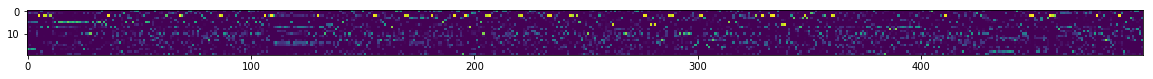

In [25]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [26]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
22000,0.118019,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.311015,0.000000,0.000000,0.000000,0.000000,0.204477,0.0,0.0,0.016397,0.000000,0.000000,0.35009
22001,0.000000,0.0,0.000000,0.000000,0.000000,0.069279,0.000000,0.000000,0.057928,0.000000,0.240506,0.319873,0.000000,0.000000,0.0,0.0,0.029435,0.282978,0.000000,0.00000
22002,0.312160,0.0,0.000000,0.000000,0.115222,0.000000,0.148929,0.000000,0.000000,0.000000,0.000000,0.094235,0.076769,0.252685,0.0,0.0,0.000000,0.000000,0.000000,0.00000
22003,0.000000,0.0,0.000000,0.008735,0.012599,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042903,0.000000,0.556092,0.0,0.0,0.070452,0.167202,0.142017,0.00000
22004,0.193692,0.0,0.104648,0.000000,0.000000,0.000000,0.000000,0.018839,0.000000,0.353279,0.000000,0.000000,0.000000,0.035176,0.0,0.0,0.114156,0.000000,0.180211,0.00000


## DataViz

In [27]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,2008,2,0.458049,0.000000,0.0,0.005555,0.027092,0.003151,0.059277,...,0.000000,0.128474,0.097935,0.181535,0.00000,0.000000,0.021099,0.000000,0.017833,0.000000
1,1,2008,2,0.632395,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.088573,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,2008,2,0.036397,0.000000,0.0,0.000000,0.000000,0.000000,0.012910,...,0.000000,0.000000,0.167348,0.680242,0.00000,0.000000,0.000000,0.000000,0.000000,0.103104
3,3,2008,2,0.000000,0.054927,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.153039,0.000000,0.128450,0.04937,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,2008,2,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.233583,0.416360,0.000000,0.000000,0.00000,0.072046,0.047714,0.030706,0.000000,0.007727


In [28]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (132, 20)


topic_0    topic_1   topic_2    topic_3    topic_4    topic_5  \
year month                                                                    
2008 2       5.750831   3.028122  0.366248   1.682246   1.764475   9.237143   
     3      27.839293  14.705786  5.423879  10.517068  11.101358  14.742620   
     4      18.609726  13.692340  2.065144  19.922115   7.165498  20.832203   
     5      13.977764  14.976894  2.284893  31.479622  10.945243  29.705051   
     6      13.525900  12.908583  3.039244  18.486706   5.370056  16.250610   

              topic_6    topic_7    topic_8    topic_9   topic_10   topic_11  \
year month                                                                     
2008 2       1.154420   6.446889  13.813206   2.340192   7.353676  11.294718   
     3       7.457492  21.922983  27.066565  10.179429  20.799583  33.664326   
     4       6.857869  18.996876  23.180746  17.594730  13.594214  34.823315   
     5      10.352452  33.330692  32.124313  12.705651  10.853239  47.005062   
     6       8.947408  40.165588  15.848350  14.826854  12.531438  34.172592   

             topic_12   topic_13  topic_14   topic_15   topic_16   topic_17  \
year month                                                                    
2008 2       1.386624   9.667122  0.791213   9.785063   3.731860   6.048367   
     3      17.492453  48.577782  2.795205  27.188448  15.041641  23.129057   
     4      15.282094  48.402119  2.689918  28.218113  17.663704  11.013587   
     5      12.541442  48.095776  5.841259  36.593739  22.289715  14.462296   
     6      12.838906  44.116467  2.100608  32.488083  17.957937   7.807408   

             topic_18  topic_19  
year month                       
2008 2       3.539603  1.817984  
     3       8.610022  7.745017  
     4       7.815551  8.580138  
     5      11.137048  7.297853  
     6       8.017544  7.599723

### straightforward matrix heatmap

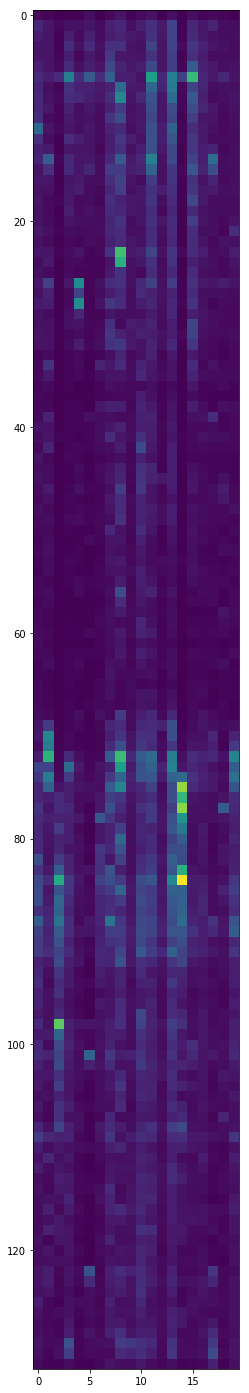

In [29]:
plt.figure(figsize=(5, 25))
plt.imshow(gb[topics])

## pygal

In [30]:
import pygal
from IPython.display import SVG, HTML

In [31]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [32]:
max(gb['topic_1'].values)

154.72348

In [33]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [34]:
line_chart.render_to_file(f"data/visualization/{'-'.join(name_dataset.split('.'))}_pygal.svg")

## joypy

In [35]:
import joypy # !pip install joypy

In [36]:
print(joined.shape)
joined.head()

(45046, 23)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,2008,2,0.458049,0.000000,0.0,0.005555,0.027092,0.003151,0.059277,...,0.000000,0.128474,0.097935,0.181535,0.00000,0.000000,0.021099,0.000000,0.017833,0.000000
1,1,2008,2,0.632395,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.088573,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,2008,2,0.036397,0.000000,0.0,0.000000,0.000000,0.000000,0.012910,...,0.000000,0.000000,0.167348,0.680242,0.00000,0.000000,0.000000,0.000000,0.000000,0.103104
3,3,2008,2,0.000000,0.054927,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.153039,0.000000,0.128450,0.04937,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,2008,2,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.233583,0.416360,0.000000,0.000000,0.00000,0.072046,0.047714,0.030706,0.000000,0.007727


In [37]:
joined['date'] = ['{}-{:02d}-01'.format(a, b) for a, b in joined[['year', 'month']].values]
cols = [c for c in joined.columns if c.startswith('topic')]

joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,date
0,0,2008,2,0.458049,0.000000,0.0,0.005555,0.027092,0.003151,0.059277,...,0.128474,0.097935,0.181535,0.00000,0.000000,0.021099,0.000000,0.017833,0.000000,2008-02-01
1,1,2008,2,0.632395,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.088573,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2008-02-01
2,2,2008,2,0.036397,0.000000,0.0,0.000000,0.000000,0.000000,0.012910,...,0.000000,0.167348,0.680242,0.00000,0.000000,0.000000,0.000000,0.000000,0.103104,2008-02-01
3,3,2008,2,0.000000,0.054927,0.0,0.000000,0.000000,0.000000,0.000000,...,0.153039,0.000000,0.128450,0.04937,0.000000,0.000000,0.000000,0.000000,0.000000,2008-02-01
4,4,2008,2,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.416360,0.000000,0.000000,0.00000,0.072046,0.047714,0.030706,0.000000,0.007727,2008-02-01


In [38]:
dd = joined[cols + ['date']].melt('date', var_name='topic', value_name='mentions')
dd = dd[dd['mentions'] > 0]

dd.head()

,date,topic,mentions
0,2008-02-01,topic_0,0.458049
1,2008-02-01,topic_0,0.632395
2,2008-02-01,topic_0,0.036397
7,2008-02-01,topic_0,0.735568
8,2008-02-01,topic_0,0.002619


In [39]:
dd2 = dd.groupby(['date','topic']).sum()
dd2.head()

mentions
date       topic              
2008-02-01 topic_0    5.750831
           topic_1    3.028122
           topic_10   7.353676
           topic_11  11.294718
           topic_12   1.386624

In [40]:
dd2=dd2.reset_index()
dd2.head()

,date,topic,mentions
0,2008-02-01,topic_0,5.750831
1,2008-02-01,topic_1,3.028122
2,2008-02-01,topic_10,7.353676
3,2008-02-01,topic_11,11.294718
4,2008-02-01,topic_12,1.386624


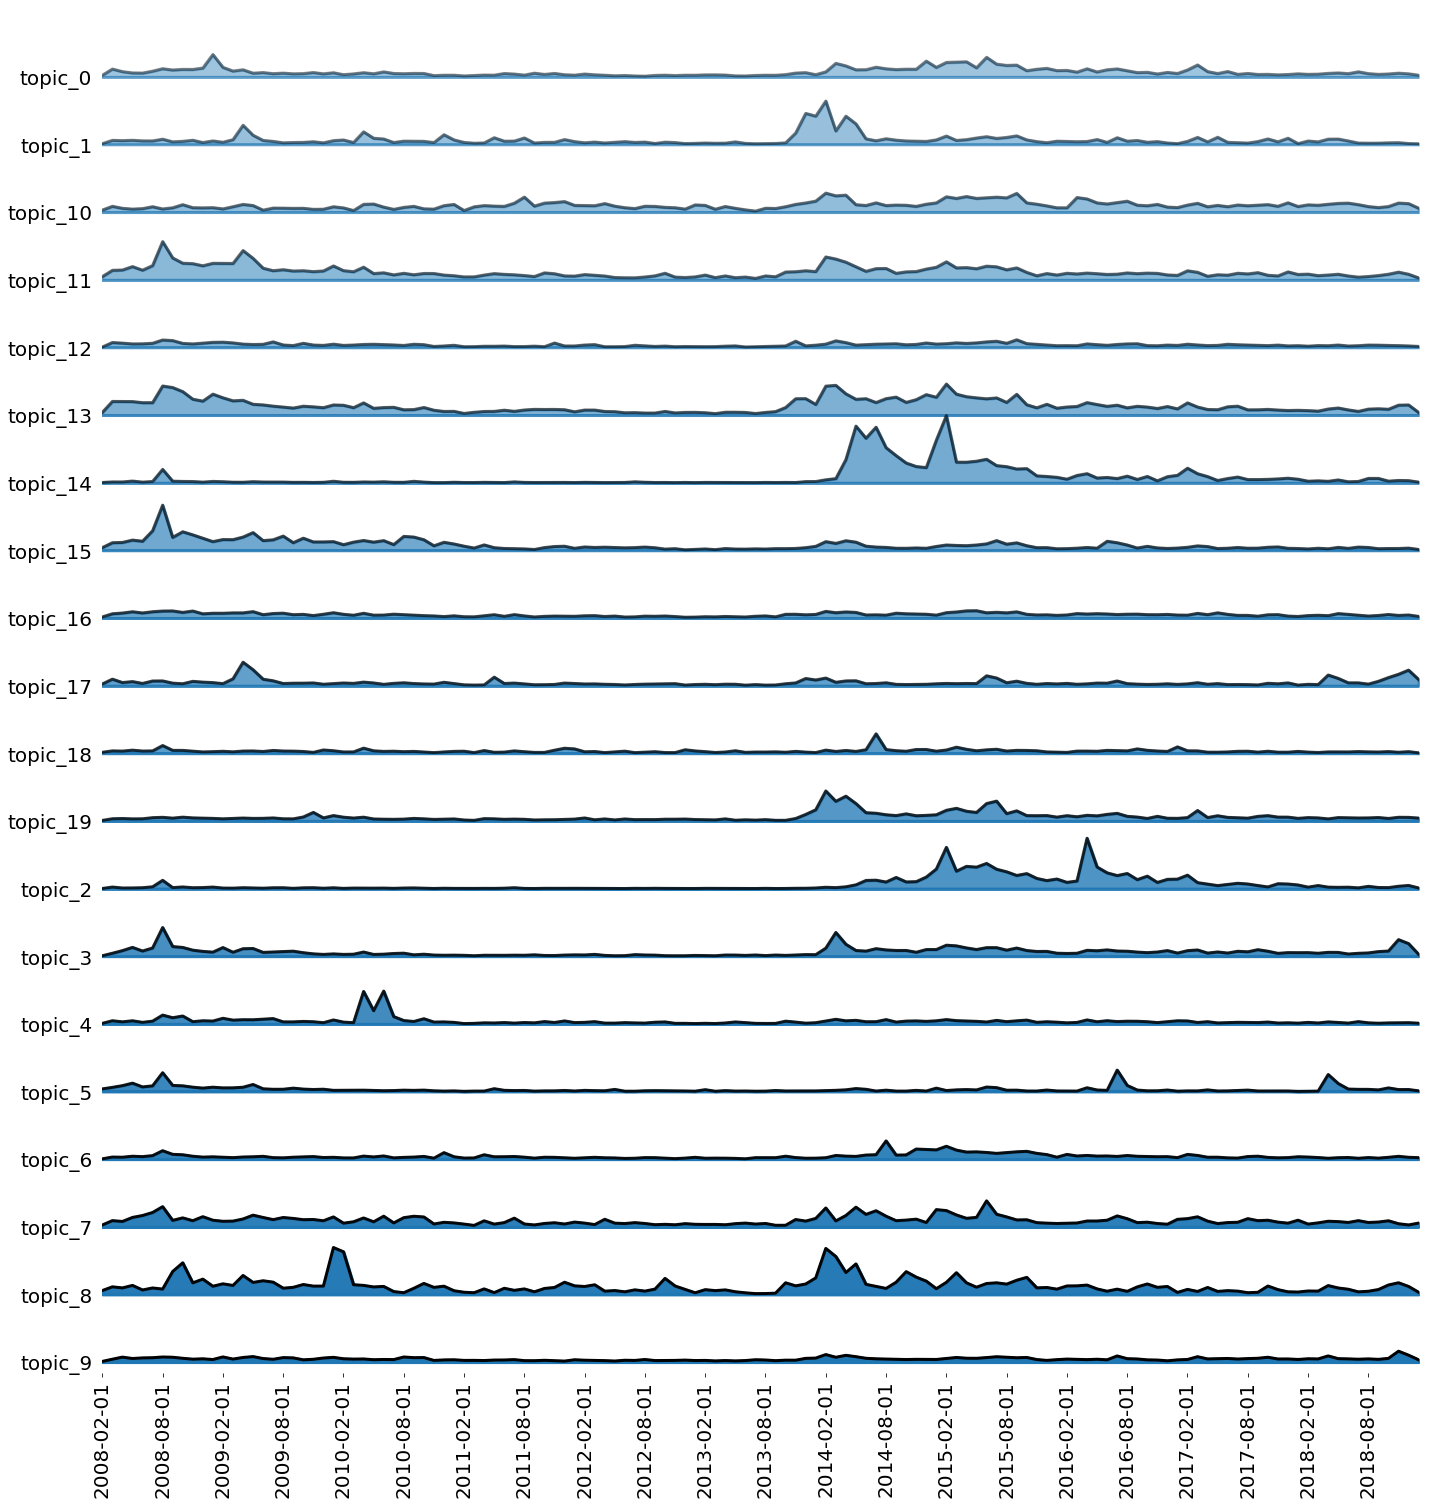

In [41]:
labels = sorted(joined['date'].unique())
fig, axes = joypy.joyplot(dd2, by='topic', column='mentions', figsize=(20, 20),
                          xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True,
                          linecolor="k",linewidth=3,
                          kind='values', fade=True, xrot=90,
                          x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [42]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")